<h1><center><font size="6">Default Credit Card Clients Predictive Models</font></center></h1>


<img src="https://kaggle2.blob.core.windows.net/datasets-images/306/666/d68d599bfe6995fa5772df1e82c4e83c/dataset-card.jpg" width="400"></img>


# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Load packages</a>  
- <a href='#3'>Read the data</a>  
- <a href='#4'>Check the data</a>  
    - <a href='#41'>Glimpse the data</a>  
    - <a href='#42'>Check missing data</a>
    - <a href='#43'>Check data unbalance</a>
- <a href='#5'>Data exploration</a>
- <a href='#6'>Predictive models</a>  
    - <a href='#61'>RandomForrestClassifier</a> 
    - <a href='#62'>AdaBoostClassifier</a>     
    - <a href='#63'>XGBoost</a> 
    - <a href='#64'>LightGBM</a> 
- <a href='#7'>Conclusions</a>
- <a href='#8'>References</a>


# <a id="1">Introduction</a>  


## Dataset

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from **April 2005** to **September 2005**. 

## Content

There are 25 variables:

* **ID**: ID of each client
* **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* **SEX**: Gender (1=male, 2=female)
* **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
* **AGE**: Age in years
* **PAY_0**: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
* **PAY_2**: Repayment status in August, 2005 (scale same as above)
* **PAY_3**: Repayment status in July, 2005 (scale same as above)
* **PAY_4**: Repayment status in June, 2005 (scale same as above)
* **PAY_5**: Repayment status in May, 2005 (scale same as above)
* **PAY_6**: Repayment status in April, 2005 (scale same as above)
* **BILL_AMT1**: Amount of bill statement in September, 2005 (NT dollar)
* **BILL_AMT2**: Amount of bill statement in August, 2005 (NT dollar)
* **BILL_AMT3**: Amount of bill statement in July, 2005 (NT dollar)
* **BILL_AMT4**: Amount of bill statement in June, 2005 (NT dollar)
* **BILL_AMT5**: Amount of bill statement in May, 2005 (NT dollar)
* **BILL_AMT6**: Amount of bill statement in April, 2005 (NT dollar)
* **PAY_AMT1**: Amount of previous payment in September, 2005 (NT dollar)
* **PAY_AMT2**: Amount of previous payment in August, 2005 (NT dollar)
* **PAY_AMT3**: Amount of previous payment in July, 2005 (NT dollar)
* **PAY_AMT4**: Amount of previous payment in June, 2005 (NT dollar)
* **PAY_AMT5**: Amount of previous payment in May, 2005 (NT dollar)
* **PAY_AMT6**: Amount of previous payment in April, 2005 (NT dollar)
* **default.payment.next.month**: Default payment (1=yes, 0=no)



# <a id="2">Load packages</a>

In [220]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
import xgboost as xgb

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = True

import os

if(IS_LOCAL):
    PATH="../input/default-of-credit-card-clients-dataset"
else:
    PATH="../input"
print(os.listdir(PATH))

['UCI_Credit_Card.csv']


# <a id="3">Read the data</a>

In [221]:
data_df = pd.read_csv(PATH+"/UCI_Credit_Card.csv")

# <a id="4">Check the data</a>

In [222]:
print("Default Credit Card Clients data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Default Credit Card Clients data -  rows: 30000  columns: 25


## <a id="41">Glimpse the data</a>

We start by looking to the data features (first 5 rows).

In [223]:
data_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Let's look into more details to the data.

In [224]:
data_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


There are 30,000 distinct credit card clients.  

The average value for the amount of credit card limit is 167,484. The standard deviation is unusually large, max value being 1M.

Education level is mostly graduate school and university.

Most of the clients are either marrined or single (less frequent the other status).

Average age is 35.5 years, with a standard deviation of 9.2.

As the value 0 for default payment means 'not default' and value 1 means 'default', the mean of 0.221 means that there are 22.1% of credit card contracts that will default next month (will verify this in the next sections of this analysis).


## <a id="42">Check missing data</a>  

Let's check if there is any missing data.

In [225]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,default.payment.next.month,PAY_6,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,BILL_AMT1,PAY_AMT6,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,ID
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

## <a id="43">Data unbalance</a>

Let's check data unbalance with respect with *target* value, i.e. **default.payment.next.month**.

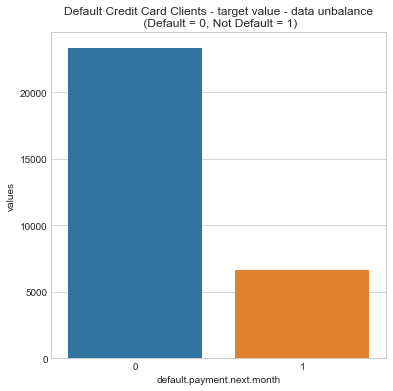

In [226]:
temp = data_df["default.payment.next.month"].value_counts()
df = pd.DataFrame({'default.payment.next.month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default.payment.next.month', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

A number of **6,636** out of **30,000** (or **22%**) of clients will default next month. The data has not a large unbalance with respect of the target value (default.payment.next.month).

# <a id="5">Data exploration</a>

## Amount of credit limit 

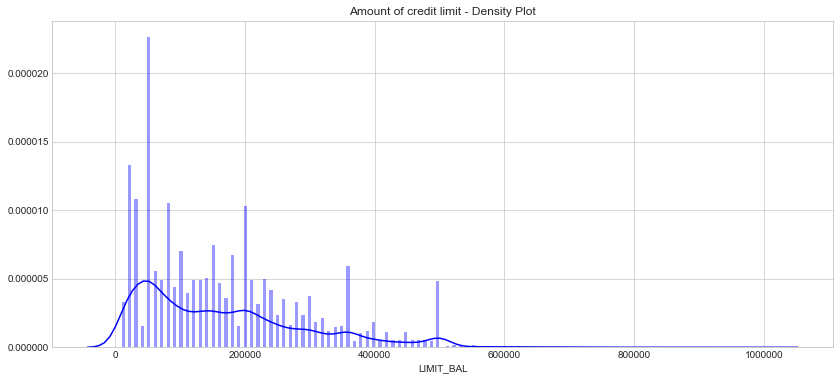

In [227]:
plt.figure(figsize = (14,6))
plt.title('Amount of credit limit - Density Plot')
sns.set_color_codes("pastel")
sns.distplot(data_df['LIMIT_BAL'],kde=True,bins=200, color="blue")
plt.show()

Largest group of amount of credit limit is apparently for amount of 50K. Let's verify this.

In [228]:
data_df['LIMIT_BAL'].value_counts().shape

(81,)

In [229]:
There are 81 distinct values for amount of credit limit.

SyntaxError: invalid syntax (<ipython-input-229-c830f143a829>, line 1)

In [230]:
data_df['LIMIT_BAL'].value_counts().head(5)

50000.0     3365
20000.0     1976
30000.0     1610
80000.0     1567
200000.0    1528
Name: LIMIT_BAL, dtype: int64

Indeed, the largest number of credit cards are with limit of 50,000 (3365), followed by 20,000 (1976) and 30,000 (1610).

## Amount of credit limit grouped by default payment next month

Let's visualize the density plot for amount of credit limit (LIMIT_BAL), grouped by default payment next month.

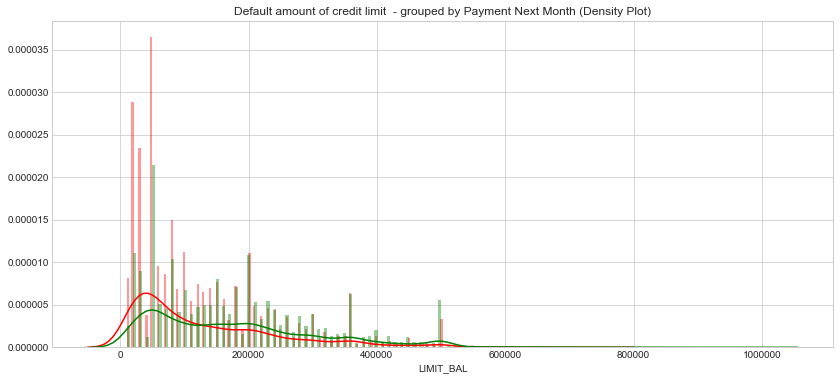

In [231]:
class_0 = data_df.loc[data_df['default.payment.next.month'] == 0]["LIMIT_BAL"]
class_1 = data_df.loc[data_df['default.payment.next.month'] == 1]["LIMIT_BAL"]
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit  - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

Most of defaults are for credit limits 0-100,000 (and density for this interval is larger for defaults than for non-defaults). Larger defaults number are for the amounts of **50,000**, **20,000** and **30,000**.

## Credit limit vs. sex

Let's check the credit limit distribution vs. sex. For the sex, 1 stands for male and 2 for female.

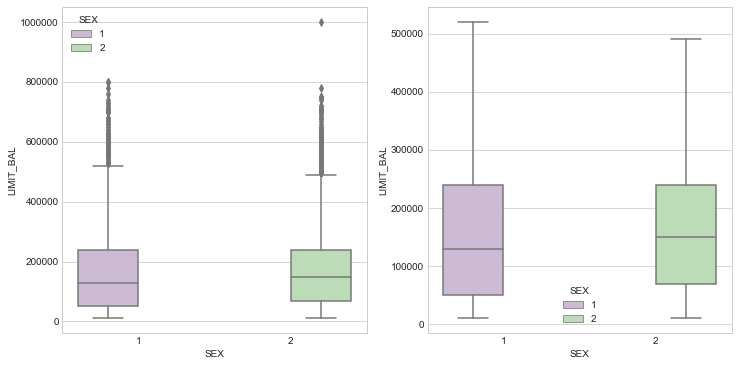

In [232]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="SEX", y="LIMIT_BAL", hue="SEX",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="SEX", y="LIMIT_BAL", hue="SEX",data=data_df, palette="PRGn",showfliers=False)
plt.show();

The limit credit amount is quite balanced between sexes. The males have a slightly smaller Q2 and larger Q3 and Q4 and a lower mean. The female have a larger outlier max value (1M NT dollars).

## Features correlation


For the numeric values, let's represent the features correlation.


Let's check the correlation of Amount of bill statement in April - September 2005.

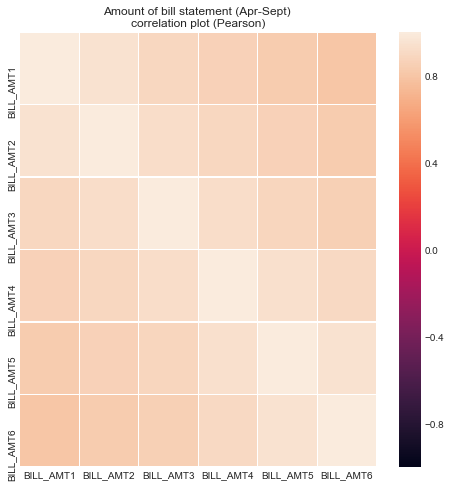

In [233]:
var = ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']

plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.


Let's check the correlation of Amount of previous payment in April - September 2005.

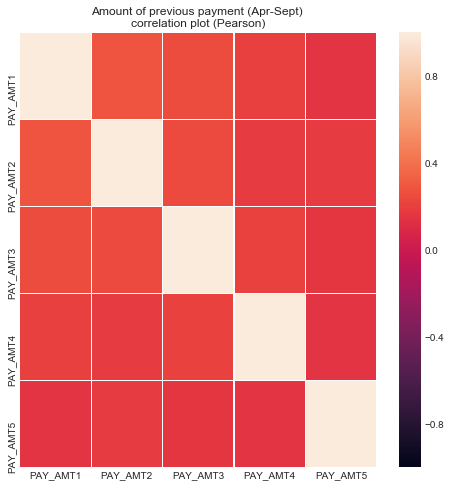

In [234]:
var = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

plt.figure(figsize = (8,8))
plt.title('Amount of previous payment (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

There are no correlations between amounts of previous payments for April-Sept 2005.

Let's check the correlation between Repayment status in April - September 2005.

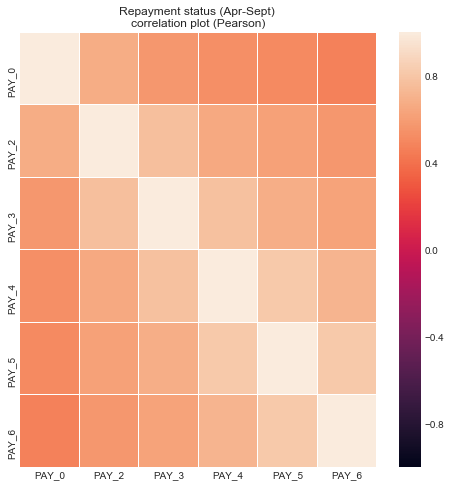

In [235]:
var = ['PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

plt.figure(figsize = (8,8))
plt.title('Repayment status (Apr-Sept) \ncorrelation plot (Pearson)')
corr = data_df[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1)
plt.show()

Correlation is decreasing with distance between months. Lowest correlations are between Sept-April.


## Sex, Education, Age and Marriage


Let's show sex, education, age and marriage distributions.

We start by showing the boxplots with age distribution grouped by marriage status and sex.

Marriage status meaning is:

* 0 : unknown (let's consider as others as well)
* 1 : married
* 2 : single
* 3 : others

Sex meaning is:

* 1 : male
* 2 : female


In [236]:
def boxplot_variation(feature1, feature2, feature3, width=16):
    fig, ax1 = plt.subplots(ncols=1, figsize=(width,6))
    s = sns.boxplot(ax = ax1, x=feature1, y=feature2, hue=feature3,
                data=data_df, palette="PRGn",showfliers=False)
    s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.show();

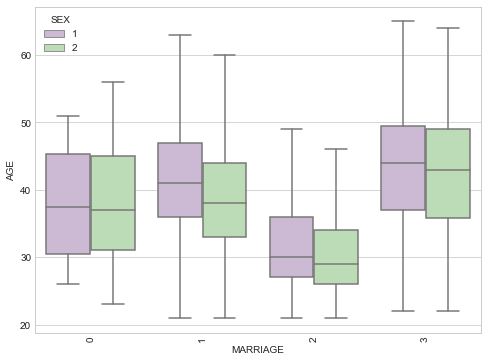

In [237]:
boxplot_variation('MARRIAGE','AGE', 'SEX',8)

It looks like Married status 3 (others), with mean values over 40 and Q4 values over 60 means mostly vidowed or divorced whilst Married status 0 could be not specified or divorced, as Q1 values are above values for married of both sexes.

Married males have mean age above married women. Unmarried males have mean value for age above unmarried women as well but closer. Q3 abd Q4 values for married man are above corresponding values for married women.


Let's show the boxplots with age distribution grouped by education and marriage.

Education status meaning is:

* 1 : graduate school
* 2 : university
* 3 : high school
* 4 : others
* 5 : unknown
* 6 : unknow


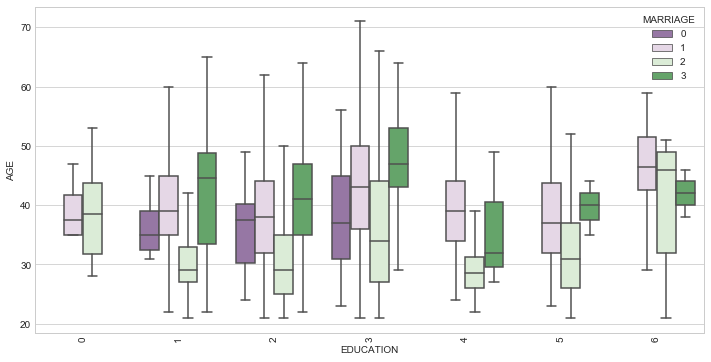

In [238]:
boxplot_variation('EDUCATION','AGE', 'MARRIAGE',12)

## Age, sex and credit amount limit


Let's show the  boxplots with credit amount limit distribution grouped by age and sex.



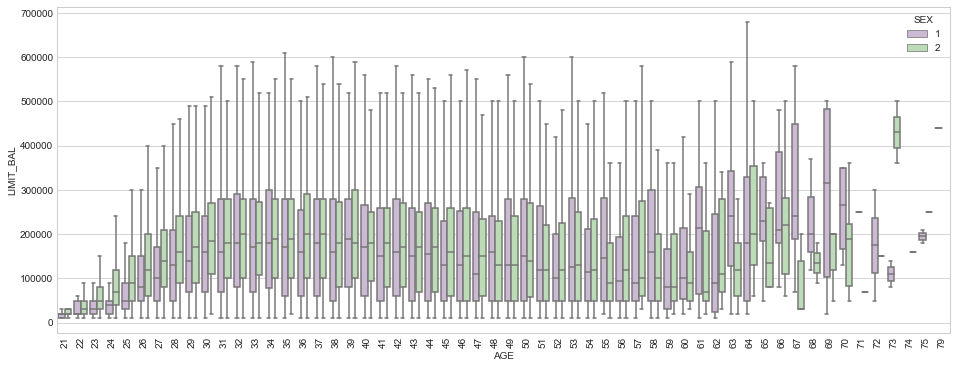

In [239]:
boxplot_variation('AGE','LIMIT_BAL', 'SEX',16)

Mean, Q3 and Q4 values are increasing for both male and female with age until aroung 35 years and then they are oscilating and get to a maximum of Q4 for males at age 64.

Mean values are generally smaller for males than for females, with few exceptions, for example at age 39, 48, until approximately 60, where mean values for males are generally larger than for females.



## Marriage status, education level and credit amount limit


Let's show the  boxplots with credit amount limit distribution grouped by marriage status and education level.

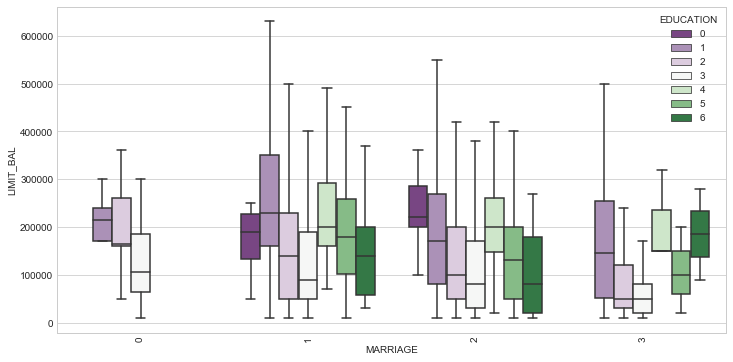

In [240]:
boxplot_variation('MARRIAGE','LIMIT_BAL', 'EDUCATION',12)

# <a id="6">Predictive models</a>  



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [241]:
target = 'default.payment.next.month'
predictors = [  'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 
                'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1','BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

### Split data in train and validation set

Let's define train and validation sets.

In [242]:
train_df, val_df = train_test_split(data_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

We also make copies of the train_df and val_df for later usage.

In [243]:
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

Let's start with a RandomForrestClassifier <a href='#8'>[3]</a>   model.

## <a id="61">RandomForestClassifier</a>


### Define model parameters

Let's set the parameters for the model.

Let's run a model using the training set for training. Then, we will use the validation set for validation. 

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)** <a href='#8'>[4]</a>.  Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

In [244]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [245]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=4,
            oob_score=False, random_state=2018, verbose=False,
            warm_start=False)

Let's now predict the **target** values for the **val_df** data, using **predict** function.

In [246]:
preds = clf.predict(val_df[predictors])

Let's also visualize the features importance.

### Features importance

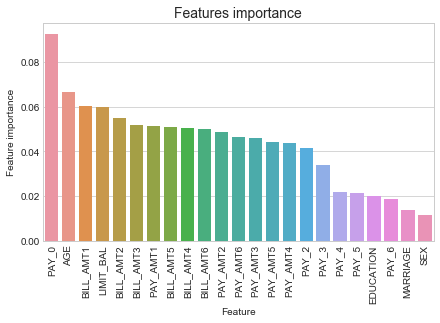

In [247]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


The most important features are **PAY_0**, **AGE**, **BILL_AMT1**, **LIMIT_BAL**, **BILL_AMT2**, **BILL_AMT3**.


### Confusion matrix

Let's show a confusion matrix for the results we obtained. 

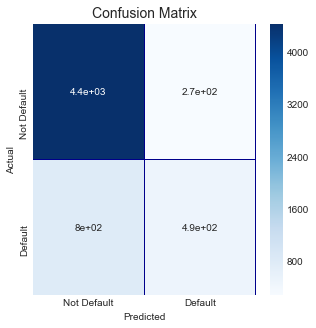

In [248]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Default', 'Default'],
            yticklabels=['Not Default', 'Default'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

We also calculate area under curve (receiver operator characteristic).

In [249]:
roc_auc_score(val_df[target].values, preds)

0.66250187415662953

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.66**.


**Note**: we will further develop this Kernel to use for RandomForrestClassifier **dummified variables** for the **categorical features**.





## <a id="62">AdaBoostClassifier</a>


AdaBoostClassifier stands for Adaptive Boosting Classifier <a href='#8'>[5]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [250]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

### Fit the model

Let's fit the model.

In [251]:
clf.fit(train_df[predictors], train_df[target].values)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.8, n_estimators=100, random_state=2018)

### Predict the target values

Let's now predict the **target** values for the **val_df** data, using predict function.

In [252]:
preds = clf.predict(val_df[predictors])

### Features importance

Let's see also the features importance.

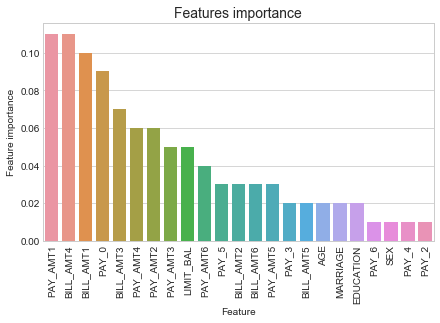

In [253]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   

### Confusion matrix

Let's visualize the confusion matrix.

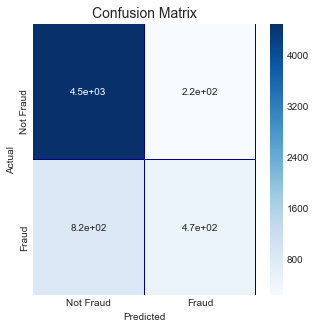

In [254]:
cm = pd.crosstab(val_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

Let's calculate also the ROC-AUC.


### Area under curve

In [255]:
roc_auc_score(val_df[target].values, preds)

0.65880485360535124

The ROC-AUC score obtained with AdaBoostClassifier is 0.65.

## <a id="63">XGBoost</a>

XGBoost is a gradient boosting algorithm <a href='#8'>[6]</a>.

Let's prepare the model.

### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [256]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

### Train the model

Let's train the model. 

In [257]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.692712	valid-auc:0.698104
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[50]	train-auc:0.769358	valid-auc:0.76466
[100]	train-auc:0.777265	valid-auc:0.772154
[150]	train-auc:0.782968	valid-auc:0.776715
[200]	train-auc:0.786954	valid-auc:0.778937
[250]	train-auc:0.789674	valid-auc:0.779818
[300]	train-auc:0.792069	valid-auc:0.780669
[350]	train-auc:0.794535	valid-auc:0.781522
[400]	train-auc:0.796471	valid-auc:0.782115
[450]	train-auc:0.797954	valid-auc:0.782598
[500]	train-auc:0.799617	valid-auc:0.78246
Stopping. Best iteration:
[453]	train-auc:0.798087	valid-auc:0.782645



The best validation score (ROC-AUC) was **0.78**, for round **453**.

### Plot variable importance

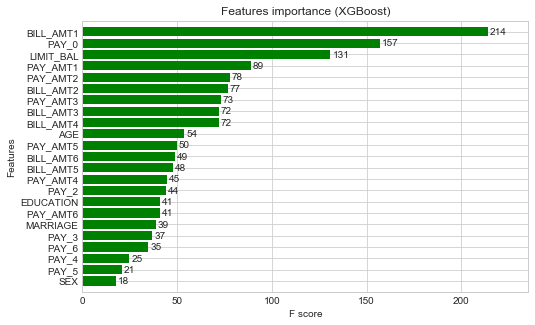

In [258]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()

## <a id="64">LightGBM</a>


Let's continue with another gradient boosting algorithm, LightGBM <a href='#8'>[7]</a> <a href='#8'>[8]</a>.


### Define model parameters

Let's set the parameters for the model.

In [259]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':20, # because training data is sightly unbalanced 
         }

### Prepare the model


Let's define the categorical features.

In [260]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

Let's prepare the model, creating the **Dataset**s data structures from the train and validation sets.

We will also initialize the Datasets with the list of the categorical features (**lgb** has a special treatment for categorical values).

In [261]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical_features)
del train_df
gc.collect()

dvalid = lgb.Dataset(val_df[predictors].values,
                     label=val_df[target].values,
                     feature_name=predictors,
                     categorical_feature=categorical_features)
del val_df
gc.collect()

22

### Run the model

Let's run the model, using the **train** function.

In [262]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

del dvalid
gc.collect()

C:\Program_Files\Anaconda3\lib\site-packages\lightgbm\basic.py:1005: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.783128	valid's auc: 0.777243
[100]	train's auc: 0.792162	valid's auc: 0.783477
[150]	train's auc: 0.797665	valid's auc: 0.784803
[200]	train's auc: 0.802372	valid's auc: 0.785469
[250]	train's auc: 0.8068	valid's auc: 0.78638
[300]	train's auc: 0.811129	valid's auc: 0.78645
Early stopping, best iteration is:
[297]	train's auc: 0.81098	valid's auc: 0.786529


32

Best validation score  was obtained for round **312**, for which **AUC ~= 0.78**.

Let's plot variable importance.

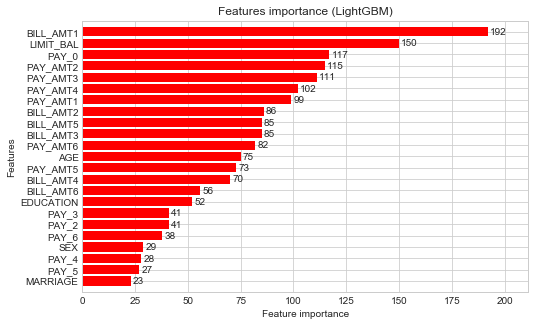

In [263]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
lgb.plot_importance(model, height=0.8, title="Features importance (LightGBM)", ax=ax,color="red") 
plt.show()

### Training and validation using cross-validation

Let's use now cross-validation. We will use cross-validation (KFolds) with 5 folds. Data is divided in 5 folds and, by rotation, we are training using 4 folds (n-1) and validate using the 5th (nth) fold.

In [264]:
kf = KFold(n_splits = NUMBER_KFOLDS, random_state = RANDOM_STATE, shuffle = True)
for train_index, test_index in kf.split(data_df):
    train_X, valid_X = data_df.iloc[train_index], data_df.iloc[test_index]

    dtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values,
                     feature_name=predictors)

    dvalid = lgb.Dataset(valid_X[predictors].values, label=valid_X[target].values,
                     feature_name=predictors)

    evals_results = {}
    model =  lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  early_stopping_rounds=EARLY_STOP,
                  verbose_eval=VERBOSE_EVAL, 
                  feval=None)

Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.783854	valid's auc: 0.777789
[100]	train's auc: 0.792482	valid's auc: 0.784269
[150]	train's auc: 0.797741	valid's auc: 0.785782
[200]	train's auc: 0.802975	valid's auc: 0.786108
Early stopping, best iteration is:
[184]	train's auc: 0.801468	valid's auc: 0.78616
Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.785431	valid's auc: 0.765756
[100]	train's auc: 0.794866	valid's auc: 0.774186
[150]	train's auc: 0.800396	valid's auc: 0.776067
[200]	train's auc: 0.805189	valid's auc: 0.776735
[250]	train's auc: 0.809684	valid's auc: 0.776995
[300]	train's auc: 0.813641	valid's auc: 0.776478
Early stopping, best iteration is:
[254]	train's auc: 0.810053	valid's auc: 0.777105
Training until validation scores don't improve for 50 rounds.
[50]	train's auc: 0.781776	valid's auc: 0.785396
[100]	train's auc: 0.790927	valid's auc: 0.789485
[150]	train's auc: 0.796976	valid's auc: 0.79014

The average validation **AUC** for the 5 folds obtained was **0.78**, with values between **0.778** and **0.79**.

# <a id="7">Conclusions</a>

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features. 
We then investigated four predictive models.
We started with RandomForrestClassifier, for which we obtained an AUC scode of **0.66**. We followed with an AdaBoostClassifier model, with lower AUC score (**0.65**). We the followed with a XGBoost model, for which the AUC score obtained was **0.77**. We then presented the data to a LightGBM model. We used both train-validation split and cross-validation to evaluate the model effectiveness to predict the target value, i.e. detecting if a credit card client  will default next month. With both methods for LightGBM the obtained values of AUC for the validation set were around **0.78**.

# <a id="8">References</a>

[1] Default Credit Card Clients Dataset,  https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/  
[2] Principal Component Analysis, Wikipedia Page, https://en.wikipedia.org/wiki/Principal_component_analysis  
[3] RandomForrestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
[4] ROC-AUC characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
[5] AdaBoostClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html  
[5] XGBoost Python API Reference, http://xgboost.readthedocs.io/en/latest/python/python_api.html  
[6] LightGBM Python implementation, https://github.com/Microsoft/LightGBM/tree/master/python-package  
[7] LightGBM algorithm, https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf   

